In [1]:
!pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.4 MB 1.2 MB/s 
     |████████████████████████████████| 465 kB 54.2 MB/s 


In [2]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from collections import Counter
import statistics as stats
import re

from konlpy.tag import Okt
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_multilabel_classification
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression

In [3]:
songs = pd.read_excel('/content/song_lyrics_labeled (1).xlsx')
songs.dropna(inplace=True)
songs

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,year,singer,names,categories,lyrics,hope,money,...,friend,equal,swear,nature,regret,memory,sf,food,confi,enjoy
0,0,0,0,1964,금호동,내일또만납시다,희망,하루의 일을 끝내고 돌아가는거리엔 사람의 물결하늘엔 별이 하나 둘 반짝이면가로등 하...,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1964,최숙자,눈물의연평도,"후회, 자연",조기를 담뿍잡아기폭을 올리고온다던 그배는어이하여 아니오나수평선 바라보며그이름 부르면...,0,0,...,0,0,0,1,1,0,0,0,0,0
2,2,2,2,1964,이미자,님이라부르리까,사랑,<1절 임이라 부르리까 당신이라고 부르리까 사랑을 하면서도 사랑을 참고사는 마음으로...,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,3,3,1964,이미자,동백아가씨,"사랑, 후회",헤일 수 없이 수많은 밤을내 가슴 도려내는 아픔에 겨워얼마나 울었던가 동백아가씨그리...,0,0,...,0,0,0,0,1,0,0,0,0,0
4,4,4,4,1964,현미,떠날때는말없이,"사랑, 후회",그 날 밤 그 자리에둘이서 만났을 때똑같은 그 순간에똑같은 마음이달빛에 젖은 채밤새...,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6195,6195,6195,7432,2021,IVE(아이브),ELEVEN,사랑,따분한 나의 눈빛이 무표정했던 얼굴이 널 보며 빛나고 있어 널 담은 눈동자는 내 ...,0,0,...,0,0,0,0,0,0,0,0,0,0
6196,6196,6196,7433,2021,다비치,매일크리스마스(EverydayChristmas),사랑,모두가 기다려온 이 겨울 두 손엔 가득 선물을 행복한 사람들 빛...,0,0,...,0,0,0,0,0,0,0,0,0,0
6197,6197,6197,7434,2021,아이유(IU),겨울잠,희망,때 이른 봄 몇 송이 꺾어다 너의 방 문 앞에 두었어 긴 잠 실컷 자고 나오면 그때...,1,0,...,0,0,0,0,0,0,0,0,0,0
6198,6198,6198,7435,2021,폴킴(PaulKim),찬란한계절,사랑,비가 내리는 반대편으로 여름을 향해 달리네 내게로 내미는 어떤 것도 끝내 붙잡지 못...,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
X = songs.lyrics
y = songs.filial

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify=y)

In [ ]:
stop_list = ['잠', '바', '워', '몸', '진짜', '언젠가', '죽다', '힘', '뭐라다', '절대', '그저', '애', '하얗다', '돌다', '누가', '크다', '늘', '다시다', '뜨겁다', '아침', '가지', '숨', '상처', '뛰다', '순', '듣다', '머리', '단지', '이상', '꼭', '어리다', '기다', '따르다', '채', '향', '떨어지다', '듯', '예', '뜨다', '아직도', '갖다', '전', '나오다']
stop_list2 = ['받다', '때문', '지다', '서다', '이름', '많이', '수가', '조금', '아래', '두', '좀', '의', '무엇', '한번']
stop_list3 = ['줄', '처럼', '누구', '뿐', '만들다', '게', '순간', '어디', '미치다', '다른', '길', '뭐', '음', '안녕', '저', '건', '하루', '그래서', '여기', '이렇다', '손', '그렇게','우', '자다', '많다', '노래', '뒤', '응', '곳', '말다', '거', '정말', '대다', '이다', '웃다', '못', '하늘', '에스', '어떻다', '없이', '해주다', '곁', '나다', '티', '모든', '이렇게', '들다']
stop_list4 = ['하다', '있다', '없다', '말', '되다', '그렇다', '생각', '걸', '그', '것', '오', '이', '다', '속','해',
 '돼다', '알', '젠', '나르다', '주다', '아기', '중', '사람', '오다','가다','않다']

In [ ]:
stop_list.extend(stop_list2)
stop_list.extend(stop_list3)
stop_list.extend(stop_list4)

In [6]:
def preprocessing(review): 
    okt = Okt()
    
    f = open('stop_list.txt')
    stop_list = f.read().split()
    
    # 1. 한글 및 공백을 제외한 문자 모두 제거.
    review_text = re.sub("[^가-힣\\s]", "", review)
    
    # 2. okt 객체를 활용해서 형태소 토큰화 + 품사 태깅
    word_review = okt.pos(review_text, stem=True)
    
    # 노이즈 & 불용어 제거
    word_review = [(token, pos) for token, pos in word_review if not token in stop_list]
    
    # 명사, 동사, 형용사 추출
    word_review = [token for token, pos in word_review if pos in ['Noun', 'Verb', 'Adjective', 'Adverb']]

    return word_review

In [7]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression

In [ ]:
# bow = CountVectorizer(tokenizer=preprocessing, min_df=5, max_df=0.9) 

# X_train_bow = bow.fit_transform(X_train)
# X_test_bow = bow.transform(X_test)

In [8]:
tfidf = TfidfVectorizer(tokenizer=preprocessing, max_features=3000, min_df=5, max_df=0.5) 

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

X_train_tfidf.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [9]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_predict
from sklearn import model_selection

In [10]:
# 분류모델을 담을 리스트 생성 
classifiers = []

# random_state 설정
random_state = 2

# 데이터프레임 생성을 위하여 알고리즘 제목 저장
clf_names = ['Decision Tree','Random Forest', 'AdaBoost', 'Extra Trees', 'Gradient Boost',
             'MLP', 'KNN', 'Support Vector', 'Logistic Regression', 'Linear Discrimination']

# 트리 기반 알고리즘
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.01))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))

# 그 외 선형, 신경망 등의 알고리즘
classifiers.append(KNeighborsClassifier())
classifiers.append(SVC(random_state=random_state))
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())

In [11]:
kfold = StratifiedKFold(n_splits=10)

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train_tfidf, y = y_train,
                                      scoring = "accuracy", cv = kfold, n_jobs=4))
    
# 모델들의 교차검증 점수의 평균과 표준편차를 계산하여 리스트에 저장
cv_means = []
cv_std = []

for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py", line 545, in fit
    X, y, ensure_min_samples=2, estimator=self, dtype=[np.float64, np.float32]
  File "/usr/local/lib/python3.7/dist-packages/sklearn/base.py", line 581, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  Fi

In [12]:
cv_results

[array([0.99395161, 0.98790323, 0.98387097, 0.9858871 , 0.98790323,
        0.99596774, 0.98991935, 0.99193548, 0.9858871 , 0.98991935]),
 array([0.98991935, 0.99193548, 0.98991935, 0.99193548, 0.98790323,
        0.99193548, 0.98790323, 0.98991935, 0.98991935, 0.98790323]),
 array([0.99193548, 0.98991935, 0.9858871 , 0.98790323, 0.9858871 ,
        0.99596774, 0.98790323, 0.99395161, 0.98185484, 0.98991935]),
 array([0.98991935, 0.99193548, 0.98991935, 0.99193548, 0.98790323,
        0.99193548, 0.98790323, 0.98991935, 0.98991935, 0.98790323]),
 array([0.98991935, 0.97983871, 0.9858871 , 0.99193548, 0.98790323,
        0.99596774, 0.99395161, 0.98991935, 0.98790323, 0.98991935]),
 array([0.98790323, 0.99596774, 0.98790323, 0.99395161, 0.98991935,
        0.99193548, 0.99193548, 0.99395161, 0.99193548, 0.98991935]),
 array([0.98991935, 0.98790323, 0.99193548, 0.99798387, 0.98991935,
        0.99193548, 0.9858871 , 0.99193548, 0.99395161, 0.98991935]),
 array([0.98991935, 0.99395161, 0.

In [13]:
results_tfidf = pd.DataFrame(cv_results, index=clf_names)
results_tfidf['mean'] = cv_means
results_tfidf['std'] = cv_std
results_tfidf

,0,1,2,3,4,5,6,7,8,9,mean,std
Decision Tree,0.993952,0.987903,0.983871,0.985887,0.987903,0.995968,0.989919,0.991935,0.985887,0.989919,0.989315,0.003612
Random Forest,0.989919,0.991935,0.989919,0.991935,0.987903,0.991935,0.987903,0.989919,0.989919,0.987903,0.989919,0.001562
AdaBoost,0.991935,0.989919,0.985887,0.987903,0.985887,0.995968,0.987903,0.993952,0.981855,0.989919,0.989113,0.003951
Extra Trees,0.989919,0.991935,0.989919,0.991935,0.987903,0.991935,0.987903,0.989919,0.989919,0.987903,0.989919,0.001562
Gradient Boost,0.989919,0.979839,0.985887,0.991935,0.987903,0.995968,0.993952,0.989919,0.987903,0.989919,0.989315,0.004234
MLP,0.987903,0.995968,0.987903,0.993952,0.989919,0.991935,0.991935,0.993952,0.991935,0.989919,0.991532,0.002518
KNN,0.989919,0.987903,0.991935,0.997984,0.989919,0.991935,0.985887,0.991935,0.993952,0.989919,0.991129,0.003149
Support Vector,0.989919,0.993952,0.989919,0.993952,0.987903,0.991935,0.987903,0.991935,0.991935,0.987903,0.990726,0.002245
Logistic Regression,0.989919,0.987903,0.987903,0.987903,0.987903,0.987903,0.987903,0.987903,0.987903,0.987903,0.988105,0.000605
Linear Discrimination,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
results_tfidf.to_excel('result_filial_o_3000_5_0.5.xlsx')

In [15]:
import matplotlib.pyplot as plt  # 그래프 그리는 용도
import matplotlib.font_manager as fm  # 폰트 관련 용도
import matplotlib as mpl

path = "/content/NanumGothicEco.otf"  # 설치된 나눔글꼴중 원하는 녀석의 전체 경로를 가져오자
font_name = fm.FontProperties(fname=path, size=10).get_name()
print(font_name)
# 폰트 지정
plt.rc('font', family=font_name)

#마이너스 깨짐현상
mpl.rc('axes', unicode_minus=False)

fm._rebuild()

NanumGothicOTF Eco


In [16]:
!pip install pyyaml==5.4.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 636 kB 5.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successfully uninstalled PyYAML-6.0


In [17]:
!pip install chart_studio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 64 kB 1.9 MB/s 
  Created wheel for retrying: filename=retrying-1.3.3-py3-none-any.whl size=11448 sha256=9a11a92fd742ed2bdc1f41714ae9feffd199a1b75d8f50184783556f440f18e6
  Stored in directory: /root/.cache/pip/wheels/f9/8d/8d/f6af3f7f9eea3553bc2fe6d53e4b287dad18b06a861ac56ddf
Successfully built retrying


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display

import pandas as pd
import numpy as np
import chart_studio.plotly as py
import cufflinks as cf
import seaborn as sns
import plotly.express as px

%matplotlib inline

# Make Plotly work in your Jupyter Notebook
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
# Use Plotly locally
cf.go_offline()

# default renderer 세팅을 바꿔주기 
# https://plotly.com/python/renderers/#setting-the-default-renderer

import plotly.io as pio
pio.renderers.default = 'colab'

In [19]:
import re 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



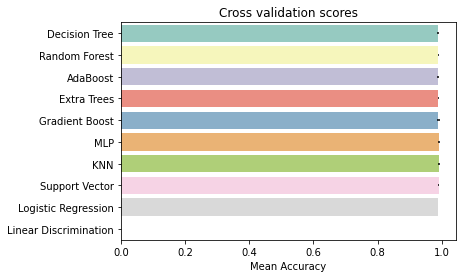

In [20]:
g = sns.barplot("mean",results_tfidf.index ,data = results_tfidf, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

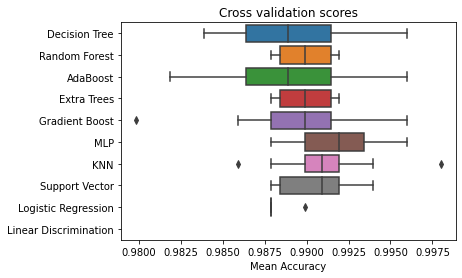

In [21]:
results2 = results_tfidf.drop(['mean', 'std'], axis=1)
g = sns.boxplot(data=results2.T, orient='h')
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

In [22]:
kfold = StratifiedKFold(n_splits=3)

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train_tfidf, y = y_train,
                                      scoring = "accuracy", cv = kfold, n_jobs=4))
    
# 모델들의 교차검증 점수의 평균과 표준편차를 계산하여 리스트에 저장
cv_means = []
cv_std = []

for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning:


3 fits failed out of a total of 3.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py", line 545, in fit
    X, y, ensure_min_samples=2, estimator=self, dtype=[np.float64, np.float32]
  File "/usr/local/lib/python3.7/dist-packages/sklearn/base.py", line 581, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File

In [23]:
RFC = RandomForestClassifier(random_state=7)


# param_grid 설정
rf_param_grid = {"max_depth": [None],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100, 300],
              "criterion": ["gini"]}

# Grid Search 객체 생성
gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

# Grid Search 실행
gsRFC.fit(X_train_tfidf,y_train)

# 최적의 파라미터 조합 출력
RFC_best = gsRFC.best_estimator_
print(RFC_best)

# 최고 점수(accuracy) 출력
print(gsRFC.best_score_)
print(gsRFC.best_params_)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
RandomForestClassifier(bootstrap=False, n_estimators=300, random_state=7)
0.9897178630184685
{'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


In [24]:
# KNN 객체 생성
KNN = KNeighborsClassifier()

# param_grid 설정
knn_param_grid = {"n_neighbors" : [1, 2, 3, 4, 5], 
                  "algorithm": ['auto'],
                  "weights" : ['uniform', 'distance'],
                  "leaf_size" : [1, 2, 3, 4, 5, 10]}

# Grid Search 객체 생성
gsKNN = GridSearchCV(KNN, param_grid = knn_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

# Grid Search 실행
gsKNN.fit(X_train_tfidf, y_train)

# 최적의 파라미터 조합 출력
KNN_best = gsKNN.best_estimator_
print(KNN_best)

# 최고 점수(accuracy) 출력
print(gsKNN.best_score_)
print(gsKNN.best_params_)


Fitting 3 folds for each of 60 candidates, totalling 180 fits
KNeighborsClassifier(leaf_size=1, n_neighbors=3, weights='distance')
0.991734276691604
{'algorithm': 'auto', 'leaf_size': 1, 'n_neighbors': 3, 'weights': 'distance'}


In [25]:
# AdaBoost 객체 생성
ADA = AdaBoostClassifier(random_state=7)

# param_grid 설정
ada_param_grid = {"n_estimators" :[1,20,30],
                  "algorithm" : ["SAMME","SAMME.R"],                  
              "learning_rate":  [0.001, 0.01, 0.1, 0.2, 0.3,1.5]}

# Grid Search 객체 생성
gsADA = GridSearchCV(ADA, param_grid = ada_param_grid, cv=kfold, scoring="accuracy", verbose = 1)

# Grid Search 실행
gsADA.fit(X_train_tfidf, y_train)

# 최적의 파라미터 조합 출력
ADA_best = gsADA.best_estimator_
print(ADA_best)

# 최고 점수(accuracy) 출력
print(gsADA.best_score_)
print(gsADA.best_params_)


Fitting 3 folds for each of 36 candidates, totalling 108 fits
AdaBoostClassifier(learning_rate=0.3, n_estimators=30, random_state=7)
0.9917340328541684
{'algorithm': 'SAMME.R', 'learning_rate': 0.3, 'n_estimators': 30}


In [26]:
# Gradient boost 객체 생성
GBC = GradientBoostingClassifier(random_state=7)

# param_grid 설정
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              }
# Grid Search 객체 생성
gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

# Grid Search 실행
gsGBC.fit(X_train_tfidf,y_train)

# 최적의 파라미터 조합 출력
GBC_best = gsGBC.best_estimator_
print(GBC_best)

# 최고 점수(accuracy) 출력
print(gsGBC.best_score_)
print(gsGBC.best_params_)


Fitting 3 folds for each of 36 candidates, totalling 108 fits
GradientBoostingClassifier(max_depth=8, min_samples_leaf=100, n_estimators=200,
                           random_state=7)
0.9895162094592832
{'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 8, 'min_samples_leaf': 100, 'n_estimators': 200}


In [27]:
#ExtraTrees 객체 생성
Ext = ExtraTreesClassifier(random_state=7)


# param_grid 설정
ex_param_grid = {"max_depth": [None],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}

# Grad Search 객체 생성
gsExt = GridSearchCV(Ext,param_grid = ex_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

# Grid Search 실행
gsExt.fit(X_train_tfidf,y_train)

# 최적의 파라미터 조합 출력
Ext_best = gsExt.best_estimator_
print(Ext_best)

# 최고 점수(accuracy) 출력
print(gsExt.best_score_)
print(gsExt.best_params_)


Fitting 3 folds for each of 18 candidates, totalling 54 fits
ExtraTreesClassifier(random_state=7)
0.9895162094592832
{'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [28]:
# Decision Tree 객체 생성
DTC = DecisionTreeClassifier(random_state=7, )

# param_grid 설정
dtc_param_grid = {"criterion" : ["gini", "entropy"],
              "min_samples_split" :   [2, 4, 6, 10],
              "min_samples_leaf" : [1,3, 5, 10]}

# Grad Search 객체 생성
gsDTC = GridSearchCV(DTC,param_grid = dtc_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

# Grid Search 실행
gsDTC.fit(X_train_tfidf,y_train)

# 최적의 파라미터 조합 출력
DTC_best = gsDTC.best_estimator_
print(DTC_best)

# 최고 점수(accuracy) 출력
print(gsDTC.best_score_)
print(gsDTC.best_params_)


Fitting 3 folds for each of 32 candidates, totalling 96 fits
DecisionTreeClassifier(min_samples_leaf=3, min_samples_split=10, random_state=7)
0.9913309695732333
{'criterion': 'gini', 'min_samples_leaf': 3, 'min_samples_split': 10}


In [29]:
#Support Vector 객체 생성
SVM = SVC(random_state=7, probability=True)

# param_grid 설정
svc_param_grid = {'kernel': ['rbf'], 
                  'gamma': [ 0.001, 0.01, 0.1, 1],
                  'C': [1, 10, 50, 100,200,300, 1000]}

# Gradient boost 객체 생성
gsSVM = GridSearchCV(SVM,param_grid = svc_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

# Grid Search 실행
gsSVM.fit(X_train_tfidf,y_train)

# 최적의 파라미터 조합 출력
SVM_best = gsSVM.best_estimator_
print(SVM_best)

# 최고 점수(accuracy) 출력
print(gsSVM.best_score_)
print(gsSVM.best_params_)


Fitting 3 folds for each of 28 candidates, totalling 84 fits
SVC(C=50, gamma=0.1, probability=True, random_state=7)
0.9913307257357977
{'C': 50, 'gamma': 0.1, 'kernel': 'rbf'}


In [30]:
# Linear Discrimination Analysis 객체 생성
MLP = MLPClassifier()

# param_grid 설정
mlp_param_grid = {'hidden_layer_sizes': [100, 150, 200, 250], 
                #   'activation': ['identity', 'logistic', 'tanh', 'relu'],
                #   'solver': ['lbfgs','sgd','adam'],
                  'alpha': [ 0.0001, 0.001, 0.01],
                #   'learning_rate': ['const  ant','invscaling','adaptive']
                }

# Gradient boost 객체 생성
gsMLP = GridSearchCV(MLP,param_grid = mlp_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

# Grid Search 실행
gsMLP.fit(X_train_tfidf,y_train)

# 최적의 파라미터 조합 출력
MLP_best = gsMLP.best_estimator_
print(MLP_best)

# 최고 점수(accuracy) 출력
print(gsMLP.best_score_)
print(gsMLP.best_params_)


Fitting 3 folds for each of 12 candidates, totalling 36 fits
MLPClassifier(hidden_layer_sizes=200)
0.9913307257357977
{'alpha': 0.0001, 'hidden_layer_sizes': 200}


In [31]:
# Linear Discrimination Analysis 객체 생성
LDA = LinearDiscriminantAnalysis()

# param_grid 설정
lda_param_grid = {'solver': ['svd','lsqr','eigen'], 
                  'n_components': [ 'False', 1, 3, 5],
                  'tol': [1.0e-13, 1.0e-9, 1.0e-8, 1.0e-6, 1.0e-5]}

# Gradient boost 객체 생성
gsLDA = GridSearchCV(LDA,param_grid = lda_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

# Grid Search 실행
gsLDA.fit(X_train_tfidf,y_train)

# 최적의 파라미터 조합 출력
LDA_best = gsLDA.best_estimator_
print(LDA_best)

# 최고 점수(accuracy) 출력
print(gsLDA.best_score_)
print(gsLDA.best_params_)


Fitting 3 folds for each of 60 candidates, totalling 180 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning:


180 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
180 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py", line 545, in fit
    X, y, ensure_min_samples=2, estimator=self, dtype=[np.float64, np.float32]
  File "/usr/local/lib/python3.7/dist-packages/sklearn/base.py", line 581, in _validate_data
    X, y = check_X_y(X, y, **check_params)


TypeError: ignored

In [32]:
# Logistic Regression 객체 생성
LGS = LogisticRegression(random_state=7)

# param_grid 설정
lgs_param_grid = {'penalty': ['l1','l2'], 
                  'C': np.logspace(0,4,10)}

# Gradient boost 객체 생성
gsLGS = GridSearchCV(LGS,param_grid = lgs_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

# Grid Search 실행
gsLGS.fit(X_train_tfidf,y_train)

# 최적의 파라미터 조합 출력
LGS_best = gsLGS.best_estimator_
print(LGS_best)

# 최고 점수(accuracy) 출력
print(gsLGS.best_score_)
print(gsLGS.best_params_)


Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning:


30 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 449, in _check_solver
    % (solver, penalty)
ValueError: Solve

LogisticRegression(C=464.15888336127773, random_state=7)
0.9917337890167328
{'C': 464.15888336127773, 'penalty': 'l2'}


In [33]:
# 예시로 Random Forest classifier가 교차검증에서 가장 좋은 성능을 보였던 파라미터 조합으로 learning curve를 출력해보자.
lc = learning_curve(gsSVM.best_estimator_, X_train_tfidf, y_train, cv=3)
lc

(array([ 330, 1074, 1818, 2562, 3306]), array([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]]), array([[0.98911729, 0.98850575, 0.98790079],
        [0.98972189, 0.99092559, 0.99153055],
        [0.99093108, 0.99032063, 0.99153055],
        [0.99153567, 0.99032063, 0.99153055],
        [0.99093108, 0.99153055, 0.99153055]]))

In [34]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    # 그래프 설정
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    # learning curve
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    
    # 학습 데이터에 대한 점수의 평균
    train_scores_mean = np.mean(train_scores, axis=1)
    # 학습 데이터에 대한 점수의 표준편차
    train_scores_std = np.std(train_scores, axis=1)
    # 검증 데이터에 대한 점수의 평균
    test_scores_mean = np.mean(test_scores, axis=1)
    # 검증 데이터에 대한 점수의 표준편차
    test_scores_std = np.std(test_scores, axis=1)
    
    # 그래프에 눈금 표시
    plt.grid()

    # fill_between() = 그래프의 두 수평 방향의 곡선 사이를 색상으로 채워서 강조
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    
    # 데이터를 연결하는 선을 plot
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    # 범례 표시
    plt.legend(loc="best")
    return plt

In [70]:
X_train_tfidf.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_predict
from sklearn import model_selection

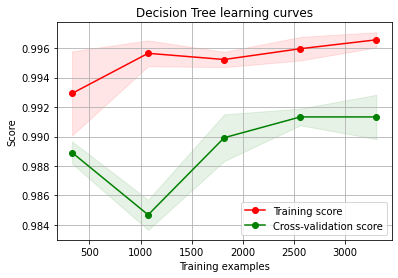

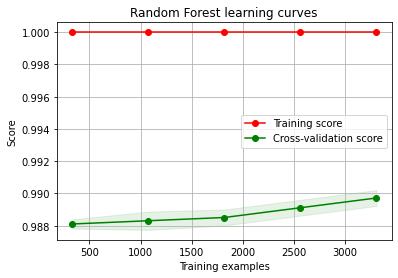

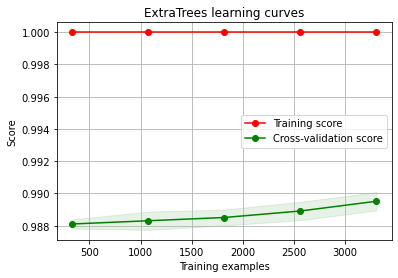

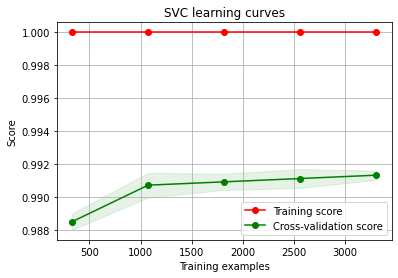

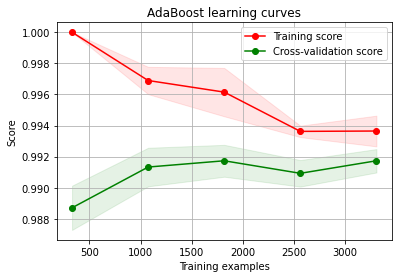

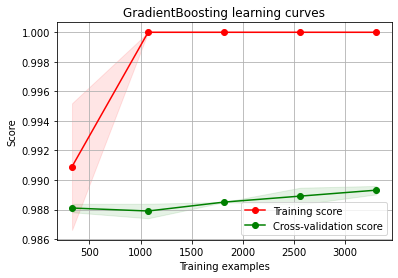

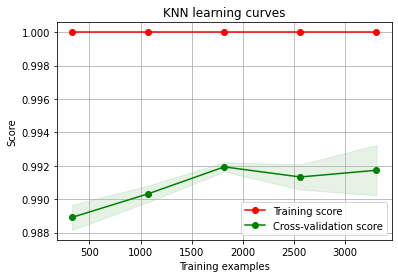

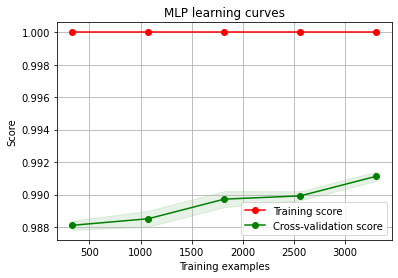

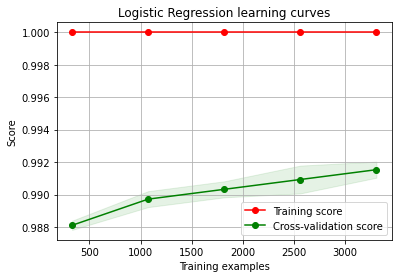

In [36]:
g = plot_learning_curve(DTC_best,"Decision Tree learning curves",X_train_tfidf,y_train,cv=kfold)
g = plot_learning_curve(RFC_best,"Random Forest learning curves",X_train_tfidf,y_train,cv=kfold)
g = plot_learning_curve(Ext_best,"ExtraTrees learning curves",X_train_tfidf,y_train,cv=kfold)
g = plot_learning_curve(SVM_best,"SVC learning curves",X_train_tfidf,y_train,cv=kfold)
g = plot_learning_curve(ADA_best,"AdaBoost learning curves",X_train_tfidf,y_train,cv=kfold)
g = plot_learning_curve(GBC_best,"GradientBoosting learning curves",X_train_tfidf,y_train,cv=kfold)
g = plot_learning_curve(KNN_best,"KNN learning curves",X_train_tfidf,y_train,cv=kfold)
g = plot_learning_curve(MLP_best,"MLP learning curves",X_train_tfidf,y_train,cv=kfold)
# g = plot_learning_curve(LDA_best,"Linear Discrimination Analysis learning curves",X_train_tfidf,y_train,cv=kfold)
g = plot_learning_curve(LGS_best,"Logistic Regression learning curves",X_train_tfidf,y_train,cv=kfold)

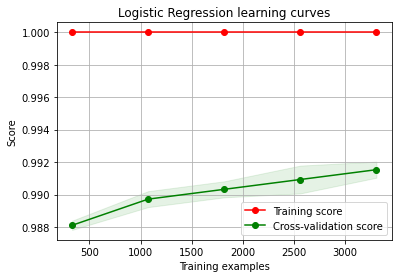

In [37]:
g = plot_learning_curve(LGS_best,"Logistic Regression learning curves",X_train_tfidf,y_train,cv=kfold)

In [38]:
#튜닝한 파라미터로 하드보팅한 후 점수를 출력해보자.
grid_hard = VotingClassifier(estimators = [('Decision Tree', DTC_best), 
                                           ('Random Forest', RFC_best),
                                           ('ExtraTrees', Ext_best),
                                           ('SVC', SVM_best),
                                           ('AdaBoost', ADA_best),
                                           ('GradientBoosting', GBC_best),
                                           ('KNN', KNN_best),
                                           # ('Linear Discrimination', LDA_best),
                                           ('MLP', MLP_best),
                                           ('Logistic Regression', LGS_best)], voting = 'hard')

grid_hard_cv = model_selection.cross_validate(grid_hard, X_train_tfidf, y_train, cv=10)

print("Hard voting on test set score mean: {:.2f}". format(grid_hard_cv['test_score'].mean() * 100))

Hard voting on test set score mean: 99.17


In [39]:
#튜닝한 파라미터로 소프트 보팅
grid_soft = VotingClassifier(estimators = [('Decision Tree', DTC_best), 
                                           ('Random Forest', RFC_best),
                                           ('ExtraTrees', Ext_best),
                                           ('SVC', SVM_best),
                                           ('AdaBoost', ADA_best),
                                           ('GradientBoosting', GBC_best),
                                           ('KNN', KNN_best),
                                           # ('Linear Discrimination', LDA_best),
                                           ('MLP', MLP_best),
                                           ('Logistic Regression', LGS_best)], voting = 'soft')

grid_soft_cv = model_selection.cross_validate(grid_soft, X_train_tfidf, y_train, cv=10)

print("Soft voting on test set score mean: {:.2f}". format(grid_soft_cv['test_score'].mean() * 100))

Soft voting on test set score mean: 99.13


In [55]:
from bs4 import BeautifulSoup
import re
import requests
from tqdm import tqdm
import pandas as pd

url = 'https://www.melon.com/new/index.htm'
headers = {'Referer':'https://www.melon.com/song/detail.htm?songId=33239419',
            'User-Agent':'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/102.0.5005.61 Safari/537.36'}

resp = requests.get(url, headers = headers)

soup = BeautifulSoup(resp.content, 'lxml')

a_titles = soup.select('table div.wrap_song_info div.rank01')
a_singers = soup.select('table div.wrap_song_info div.rank02 span.checkEllipsis')
a_nos = soup.select('a.btn.button_icons.type03.song_info')

titles, singers, nos = [], [], []

for i in tqdm(range(len(a_titles))):
  titles.append(a_titles[i].text.replace('\n', ''))
  singers.append(a_singers[i].text.replace('\n', ''))
  nos.append(str(a_nos[i]['href'].replace("javascript:melon.link.goSongDetail('", '').replace("');", "")))

dict_all = {
    'title' : titles,
    'singer': singers,
    'no': nos
}

df_all = pd.DataFrame(dict_all)
df_all

100%|██████████| 50/50 [00:00<00:00, 21763.72it/s]


,title,singer,no
0,고백,위아영 (WeAreYoung),35834213
1,Still in you (Kor ver.),"신광일, 하람",35834172
2,너의 슬픔,정지아,35831176
3,One Snowy Day(눈 내리던 어느 날) feat. SAZA(최우준),"Moon (혜원), SAZA최우준",35834219
4,사라지고 있어 (Last Scene),첸 (CHEN),35828603
5,Selfish,유아 (오마이걸),35803946
6,Loyal,"Marv, 오왼 (Owen)",35834441
7,Tap Tap,VERIVERY,35832128
8,오랫동안,성시경,35829148
9,Christmas By Your Side,레몬시티(Lemon City),35831203


In [66]:
lyrics = []

for i in tqdm(range(len(nos))):
  url = 'https://www.melon.com/song/detail.htm?songId={0}'.format(nos[i]) #nos[i])
  resp = requests.get(url, headers=headers)

  soup = BeautifulSoup(resp.content, 'lxml')

  lyric_tag = soup.select('div.wrap_lyric')

  raw = lyric_tag[0].text
  lyric = raw[:-6].strip().replace('\n', ' ')
  lyrics.append(lyric)

dict_all['lyrics'] = lyrics

df_all = pd.DataFrame(dict_all)
df_all

100%|██████████| 50/50 [00:55<00:00,  1.11s/it]


,title,singer,no,lyrics
0,고백,위아영 (WeAreYoung),35834213,처음 봤던 날 처음 했던 말나에게는 늘 소중해서떨어져 있어도 생각나같이 걸을 때 들...
1,Still in you (Kor ver.),"신광일, 하람",35834172,아직 너란 날에 멈춘 시간시계 속에 갇힌 바늘처럼다시 달려봐도 이곳에서벗어나려고 발...
2,너의 슬픔,정지아,35831176,나의 마음으로너의 슬픔을 알 수 있을까나의 기쁨으로너의 슬픔을 볼 수 있을까이렇게 ...
3,One Snowy Day(눈 내리던 어느 날) feat. SAZA(최우준),"Moon (혜원), SAZA최우준",35834219,"눈 내리던 창가에,하얀 김이 서리면 그려봅니다그대의 이름을느껴져요 지금도,차가워진 ..."
4,사라지고 있어 (Last Scene),첸 (CHEN),35828603,알아 다음 장면을그릴 수 있어초점 없는 너의 시선이말하고 있어내게 이별을 말하는 너...
5,Selfish,유아 (오마이걸),35803946,"I want U, babe, I want UI want U, babe, I want..."
6,Loyal,"Marv, 오왼 (Owen)",35834441,"Woo woo I came on to youNow u believe me,I sti..."
7,Tap Tap,VERIVERY,35832128,It's not a meme 나의 마음 같애너 궁금하면 Hit me backWe g...
8,오랫동안,성시경,35829148,어설펐던 후회마저날 지나칠 때쯤작게나마 웃을 수있을 때쯤좋아 보여 그 말마저날 다그...
9,Christmas By Your Side,레몬시티(Lemon City),35831203,Only you can bring ChristmasI want you in my l...


In [67]:
df_all.to_excel('latest_songs.xlsx')